# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Chris Larkin (c.larkin@ncl.ac.uk)
Created: 2023-10-4  
Last modified: 2021-01-23

## Preliminaries

### Parameters

In [1]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.



FileNotFoundError: [WinError 2] The system cannot find the file specified

### Functions

In [3]:
%run -i functions.py

Loaded functions.



### Network weighting tags

In [4]:
%run -i tag_lts.py
%run -i distance_cost.py

# Routing 

The function and code below currently routes between the edges of neighbourhoods, rather than from a single point to a single point. We then join the neighbourhoods up first, before considering the wider area. This wider area is derived from hexagonal tesslleations within the city boundaries.

In [36]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



### Load data

G_caralls - no addtional weighting

G_weighted - for routing. lts applied + zero bike infrastucutre cost

G_investment distance - for finding distances between points in abstract (greedy_gdf) graph. cycle infrastucre has no cost, everything else has default distance

greedy_gdf[distance] - the investment length (routed length - any infrastucture)

GT "length" - actual distance between points

In [37]:
# get graphs

locations = {}
parameterinfo = osmnxparameters['carall']
G_caralls = {}
G_caralls_simplified = {}


# reload graph to ensure we have highway type information
G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

# set up a graph for weighting by LTS, one without any weighting and one for finding the "true" distance of investment per path
G_weighted = copy.deepcopy(G_caralls[placeid])
G_investment_distance = copy.deepcopy(G_caralls[placeid])
G_default = copy.deepcopy(G_caralls[placeid])


# weight graphs
for u, v, key, data in G_weighted.edges(keys=True, data=True):
    highway = data.get('highway') 
    length = data.get('length')  
    lts = tag_lts.get(highway, 1)  # Get the LTS value, default to 1 if highway type not in tag_lts
    G_weighted[u][v][key]['length'] *= lts  # Multiply length by LTS value

for u, v, key, data in G_investment_distance.edges(keys=True, data=True):
    highway = data.get('highway') 
    length = data.get('length')  
    distance = distance_cost.get(highway, 1)  
    G_investment_distance[u][v][key]['length'] *= distance





# set the graph to route on to undirected 
G_weighted = G_weighted.to_undirected()
G_investment_distance = G_investment_distance.to_undirected()
G_default = G_default.to_undirected()

# get biketrack graph
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
G_biketrack = ox_gpkg_to_graph(gpkg_path)
G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))


# get biketrack graph without LTNs
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack_no_ltn.gpkg'
G_biketrack_no_ltn = ox_gpkg_to_graph(gpkg_path)
G_biketrack_no_ltn.remove_nodes_from(list(nx.isolates(G_biketrack)))

In [38]:
# get nodes 


for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"Processing {placeid}")
    
    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]


    # Load LTN POIs
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    

    # load tesselation points 
    tess_nodes = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg')

    exit_points = get_exit_nodes(neighbourhoods, G_biketrack)
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns
    
    ltn_nodes = all_centroids

    # add nearest node ID from G_carall 
    tess_nn = get_nearest_nodes_to_gdf(G_carall, tess_nodes)
    ltn_nn = get_nearest_nodes_to_gdf(G_carall, ltn_nodes)
    tess_nodes['osmid'] = tess_nn
    ltn_nodes['osmid'] = ltn_nn

    # combine nodes 
    combined_nodes = pd.concat([tess_nodes, ltn_nodes], ignore_index=True)

    # save them
    tess_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_tess_points.gpkg", driver="GPKG")
    ltn_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_ltn_points.gpkg", driver="GPKG")
    combined_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_combined_points.gpkg", driver="GPKG")


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Processing newcastle
newcastle: Loading and moving POIs
1 Cities loaded


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2101: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = gdf.explode().reset_index(drop=True)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1774: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ce

Processing neighbourhoods in: Newcastle Upon Tyne


### Set connection order

Build LTN triangulation

In [39]:
# Produce triangulation for LTN nodes
# only needed to set up full trianuglation, not needed later.
# ltn nodes are not ordered (nor do they need to be at this stage)
greedy_triangulation_ltns_gdf = greedy_triangulation_ltns(ltn_nodes)
ltn_node_pairs = get_ltn_node_pairs(ltn_nodes, greedy_triangulation_ltns_gdf) 


Build full triangulation

In [60]:
# Build the greedy triangulation graph using both sets of seed points
greedy_gdf, ltn_gdf, tess_gdf = build_greedy_triangulation(ltn_nodes, tess_nodes)
max_length = greedy_gdf['distance'].sum() # find the size of the fully connected graph

In [41]:
# get node pairs of ltn-to-tess, tess-to-ltn, and tess-to-tess
combined_node_pairs = get_node_pairs(combined_nodes, greedy_gdf)
combined_node_pairs = [pair for pair in combined_node_pairs if pair not in ltn_node_pairs]

Apply lts to triangulation distances

In [42]:
# find the routed distance (using level of traffic stress as a weighting) between each link, prior to calcualting the betweenness centrialty
greedy_gdf['sp_lts_route'] = greedy_gdf.apply(lambda row: nx.shortest_path(G_weighted, source=row['start_osmid'], target=row['end_osmid'], weight='length'), axis=1)
greedy_gdf['sp_lts_distance'] = greedy_gdf['sp_lts_route'].apply(lambda route: sum(G_weighted[u][v][0]['length'] for u, v in zip(route[:-1], route[1:])))
# find normal network distance for directness analysis

#G_default = copy.deepcopy(G_weighted) ## remove, G_weighted has lengths as zero so cannot be deweighted
#deweight_edges(G_default, tag_lts)

greedy_gdf['sp_true_distance'] = greedy_gdf['sp_lts_route'].apply(lambda route: sum(G_default[u][v][0]['length'] for u, v in zip(route[:-1], route[1:])))
greedy_gdf['eucl_dist'] = greedy_gdf['distance'] # save for directness analysis

In [43]:
# Create the graph from the triangulation GeoDataFrame
greedy_nx = nx.Graph()
for _, row in greedy_gdf.iterrows():
    start = row['start_osmid']
    end = row['end_osmid']
    sp_lts_distance = row['sp_lts_distance']
    greedy_nx.add_edge(start, end, geometry=row['geometry'], sp_lts_distance=sp_lts_distance)

Get shortest paths

In [44]:
shortest_paths_ltn = []
shortest_paths_other = []
for node1, node2 in ltn_node_pairs:
    try:
        path = nx.shortest_path(greedy_nx, source=node1, target=node2, weight='sp_lts_distance')
        shortest_paths_ltn.append(path)
    except nx.NetworkXNoPath:
        print(f"No path between {node1} and {node2}")
for node1, node2 in combined_node_pairs:
    try:
        path = nx.shortest_path(greedy_nx, source=node1, target=node2, weight='sp_lts_distance')
        shortest_paths_other.append(path)
    except nx.NetworkXNoPath:
        print(f"No path between {node1} and {node2}")


Find path values for ranking: Get order using sum of { (ebc of edge * (length of edge/sum of length of edges) ) } / number-of-edges.

Distance used in these functions is the routed lts distance in meters

In [45]:
# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(greedy_nx, weight='sp_lts_distance')

# find path values
ebc_ltn = get_sp_ebc_weights(ltn_node_pairs, shortest_paths_ltn, greedy_nx, edge_betweenness)
ebc_other = get_sp_ebc_weights(combined_node_pairs, shortest_paths_other, greedy_nx, edge_betweenness)

# order by betweenness path value
ebc_ltn = dict(sorted(ebc_ltn.items(), key=lambda item: item[1], reverse=True))
ebc_other = dict(sorted(ebc_other.items(), key=lambda item: item[1], reverse=True))

# set up shortest paths for looping through in budget adjustment
shortest_paths_ltn = {
    (path[0], path[-1]): [(path[i], path[i+1]) for i in range(len(path)-1)]
    for path in shortest_paths_ltn
}
shortest_paths_other =  {
    (path[0], path[-1]): [(path[i], path[i+1]) for i in range(len(path)-1)]
    for path in shortest_paths_other
}


### Compute routed edge lengths for abstract graph

This ensures we use our "budget" correctly. We first find the optimal route using the LTS tags per connection, then "deweight" the path to find the "true" length of the connection in meters. Existing infrastucture (bike paths etc) are not included in the "true" length, as we do not need to build these facilities.

In [46]:
## find the routed distance between edges in abstract GT
centroid_osmids = set(all_centroids['osmid'])
greedy_gdf['ltn_origin'] = greedy_gdf['start_osmid'].isin(centroid_osmids)
greedy_gdf['ltn_destination'] = greedy_gdf['end_osmid'].isin(centroid_osmids)

# Build a mapping from centroid osmid to neighbourhood_id
osmid_to_neigh = dict(zip(all_centroids['osmid'], all_centroids['neighbourhood_id']))

# Build a mapping from neighbourhood_id to list of exit point osmids
neigh_to_exits = defaultdict(list)
for idx, row in exit_points.iterrows():
    neigh_to_exits[row['neighbourhood_id']].append(row['osmid'])

# Compute the shortest path and store in 'sp_route'
greedy_gdf['sp_route'] = greedy_gdf.apply(lambda row: compute_routed_path_for_GT(row, G_weighted), axis=1)

# Find lengths of shortest paths on G_investment_distance
## this is the true distance of the investment, without LTS weighting but also without distances for existing infrastructure
greedy_gdf['distance'] = greedy_gdf['sp_route'].apply(
    lambda route: calculate_sp_route_distance(route, G_investment_distance)
)



Now "Distance" is the length of investment required to connect two locations via the best(shortest with weighting of LTS) path

In [47]:
del greedy_gdf['sp_route']
greedy_gdf.explore()

### Do the routing

Find the size of a fully connected network

In [48]:
## find the size of the fully connected network
total_distance = greedy_gdf['distance'].sum() 

if debug:
    print("Total distance of fully connected network: ", total_distance)

In [49]:
# set investment max to a fully connected bicycle network, and interval to 1% incremental steps
points = np.linspace(0, total_distance, 101)
# Drop 0 as we don't need to consider the empty network
investment_levels = points[1:].tolist()

Greedy triangulation "distance" is the length of the shortest path distance between edges once routed on to the network, without including any length from existing infrastucture. 

Create iterations of network growth:

In [ ]:
## betwenness
## many combinations
previous_selected_edges = set()

GT_abstracts = []
GT_abstracts_gdf = []
GTs = []
GTs_gdf = []



global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
    if debug:
        print(f"Remaining edges to add: {remaining_edges}")
    
    GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    # poipairs = connected_ltn_pairs | connected_other_pairs
    poipairs = list(GT_abstract_nx.edges())
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    GTs.append(GT)
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GTs_gdf.append(GT_edges)


    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    GTs_igraph = [ig.Graph.from_networkx(gt) for gt in GTs]
    GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs_igraph, "GT_abstracts": GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

        





## Random growth (to make a baseline comparision)

### Random links 

In [ ]:
# ## grow randomly

# random_edges = pd.Series(False, index=greedy_gdf.index)  
# distance = 0.0 # needed for budget
# Random_GT_Abstracts = []  

# for level in investment_levels:
#     # Calculate remaining budget for new edges
#     remaining_budget = level - distance
    
#     if remaining_budget > 0:
#         unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
#         if not unselected_edges.empty:
#             shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
#             cumulative_distances = shuffled_edges['distance'].cumsum()
#             within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
#             new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
#             random_edges[new_indices] = True
#             if within_budget.any():
#                 distance += cumulative_distances[within_budget].iloc[-1]
#     # save edges
#     current_gdf = greedy_gdf[random_edges].copy()

#     GT_abstract_nx = gdf_to_nx_graph(current_gdf)
#     Random_GT_Abstracts.append(current_gdf)
#     print(len(Random_GT_Abstracts))
#     print(f"Iteration with investment level {level}: {len(new_indices)} new edges added")

   
#     node_pairs = list(GT_abstract_nx.edges())
#     print(f"Node pairs in GT_abstract_nx: {node_pairs}")




In [ ]:
## many combinations
random_edges = pd.Series(False, index=greedy_gdf.index)  
distance = 0.0 # needed for budget

Random_GT_abstracts = []
Random_GTs = []
Random_GTs_gdf = []
Random_GT_abstracts_gdf = []

# reset global variables
global_processed_pairs_random = set()
cumulative_GT_indices_random = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract randomly and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    # Calculate remaining budget for new edges
    remaining_budget = D - distance
    
    if remaining_budget > 0:
        unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
        if not unselected_edges.empty:
            shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
            cumulative_distances = shuffled_edges['distance'].cumsum()
            within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
            new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
            random_edges[new_indices] = True
            if within_budget.any():
                distance += cumulative_distances[within_budget].iloc[-1]
    # save edges
    GT_abstract_gdf = greedy_gdf[random_edges].copy()
    Random_GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    Random_GT_abstracts.append(GT_abstract_nx)
    poipairs = list(GT_abstract_nx.edges()) # store currently connected points for routing

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    
    routenodepairs = [(u, v) for u, v in poipairs]
   

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs_random or tuple(reversed(poipair)) in global_processed_pairs_random:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"with a path length of", shortest_path_length , "on path: ", best_path)
                    print("The exit points were:", exit_points_a)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices_random.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices_random)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            


    Random_GTs.append(GT)
    Random_GT_nodes, Random_GT_edges = ox.graph_to_gdfs(GT) # what if GT is empty on the first random selection?
    Random_GTs_gdf.append(Random_GT_edges)
        
    

    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    Random_GTs_igraph = [ig.Graph.from_networkx(gt) for gt in Random_GTs]
    Random_GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in Random_GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": random, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs_igraph, "GT_abstracts": Random_GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, random, ".pickle", weighting=weighting)

        





## Saving files


Files are saved to a pickle. They will be of the form "newcastle_poi_LTNs_tessellation_betweenness_weighted.pickle". 

Saving as pickles

In [ ]:
prune_measure = "betweenness"

results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs, "GT_abstracts": GT_abstracts}
write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [ ]:
prune_measure = "random"

results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs, "GT_abstracts": Random_GT_abstracts}
write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

Save as geodataframes

In [ ]:
## to do

In [ ]:
breakpoint()

## Loading Saved files

Lists of graphs are loaded back in after being stored as pickles

In [ ]:
# betweeness
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_{prune_measure}_weighted.pickle"  

with open(filename, "rb") as f:
    results = pickle.load(f)


# random
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_random_weighted.pickle"  

with open(filename, "rb") as f:
    results_rnadom = pickle.load(f)

In [ ]:
# # how to access....
# investment_levels = results["prune_quantiles"]
# GTs = results["GTs"]
# GT_abstracts = results["GT_abstracts"]

# # For example, convert the first graph in GTs to GeoDataFrames
# import osmnx as ox
# nodes, edges = ox.graph_to_gdfs(GTs[0])


## Testing

### PCT

#### Loading PCT results - Predownloaded

In [102]:
# read in lines
lines = gpd.read_file(PATH["data"] + "/" + placeid + "/lines_lsoa.gpkg")
rnet = gpd.read_file(PATH["data"] + "/" + placeid + "/rnet_lsoa.gpkg")
lsoa = gpd.read_file(PATH["data"] + "/" + placeid + "/lsoa.gpkg")
lsoa_bound = gpd.read_file(PATH["data"] + "/" + placeid + "/lsoa_bound.gpkg")

# clip to boundary
boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])
#lines = gpd.clip(lines, boundary) # dont clip, otherwise lines which pass temporarily outside the boundary will be removed
rnet = gpd.clip(rnet, boundary)
lsoa = gpd.clip(lsoa, boundary)
lsoa_bound = gpd.clip(lsoa_bound, boundary)
valid_lad11cds = lsoa['lad11cd'].unique()
lines = lines[lines['lad11cd1'].isin(valid_lad11cds) & lines['lad11cd2'].isin(valid_lad11cds)] # do this instead

In [ ]:
# test = G_pct_gdfs[99]
# test.plot()
# total_length_m = test['length_m'].sum()
# total_length_m


# test1 = GTs_gdf[99]
# test1.plot()
# total_length_m = test1['length'].sum()
# total_length_m


# m = test.explore()
# test1.explore(m=m, color='red')

## PCT Demand to GT

In order to get better demand data, we can transform the desire lines from the PCT's potential demand into the ordering method of links in our greedy triangulation. This can be compared against using betweeness centraility, which up until now has been used as our proxy for demand.

PCT desire lines go from LSOA centriods, which are at a different scale to our start and end points. To deal with this, we link each lsoa to its nearest seed point. We can then aggregate the demand between seed points. 

### Join 

In [62]:
join = gpd.sjoin_nearest(lsoa[['geometry']], combined_nodes[['osmid', 'geometry']], how='left')
lsoa['nearest_seed_point'] = join['osmid']

c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


### Aggregate demand

In [63]:
# Create a dictionary mapping geo_code to nearest_seed_point (osmid)
geocode_to_osmid = lsoa.set_index('geo_code')['nearest_seed_point'].to_dict()

# Map geo_code1 and geo_code2 to their corresponding osmids
lines['osmid_start'] = lines['geo_code1'].map(geocode_to_osmid)
lines['osmid_end'] = lines['geo_code2'].map(geocode_to_osmid)

# drop lines which start or finish external to the area
lines = lines.dropna(subset=['osmid_start', 'osmid_end']).query("osmid_start != osmid_end")


# group by osmid pairs
lines['osmid_pairs'] = lines.apply(lambda row: tuple(sorted((row['osmid_start'], row['osmid_end']))), axis=1)

if debug: 
    for col in lines.columns:
        print(col)

        
# clean
lines = lines[['osmid_start', 'osmid_end', 'geometry', 'length_m', 'osmid_pairs', 'dutch_slc']]


In [64]:
lines['osmid_start'] = lines['osmid_start'].astype('int64')
lines['osmid_end'] = lines['osmid_end'].astype('int64')
lines['osmid_pairs'] = list(zip(lines['osmid_start'], lines['osmid_end']))


total_dutch_slc = lines.groupby('osmid_pairs')['dutch_slc'].sum().reset_index(name='total_dutch_slc')

# join demand to greedy triangulation
greedy_gdf['osmid_pairs'] = list(zip(greedy_gdf['start_osmid'], greedy_gdf['end_osmid']))
greedy_gdf['start_osmid'] = greedy_gdf['start_osmid'].astype('int64')
greedy_gdf['end_osmid'] = greedy_gdf['end_osmid'].astype('int64')
greedy_gdf = greedy_gdf.merge(total_dutch_slc, on ='osmid_pairs', how='left')

#greedy_gdf['total_dutch_slc'] = greedy_gdf['total_dutch_slc'].fillna(0) 


In [82]:
# Make a copy of combined_nodes and reproject to Web Mercator (EPSG:3857)
combined_nodes_web_mercator = combined_nodes.to_crs(epsg=3857)

# Buffer the geometries by 200 meters
combined_nodes_web_mercator['geometry'] = combined_nodes_web_mercator['geometry'].buffer(1000)

lsoa_web_mercator = lsoa.to_crs(epsg=3857)
lsoa_web_mercator['geometry'] = lsoa_web_mercator['geometry'].buffer(500)

In [105]:
m= lsoa.explore()
lsoa_bound.explore(m=m)
greedy_gdf.explore(m=m, color='green', opacity=0.5)
combined_nodes.explore(m=m, color='red')
#lines.explore(m=m, opacity=0.1)



In [70]:
# Filter the rows where total_dutch_slc is not equal to zero
filtered_greedy_gdf = greedy_gdf[greedy_gdf['total_dutch_slc'].notna() & (greedy_gdf['total_dutch_slc'] != 0)]

In [66]:
greedy_gdf

,geometry,start_osmid,end_osmid,distance,osmid_pairs,total_dutch_slc
0,"LINESTRING (-179845.583 7357814.685, -179259.5...",12091933082,4140896891,366.611193,"(12091933082, 4140896891)",NaN
1,"LINESTRING (-179593.518 7357152.634, -179845.5...",8254838993,12091933082,406.684872,"(8254838993, 12091933082)",NaN
2,"LINESTRING (-179703.278 7363571.886, -179300.4...",60150990,252100827,415.313673,"(60150990, 252100827)",23.38
3,"LINESTRING (-176125.064 7357619.081, -176939.8...",776327170,345643357,481.877848,"(776327170, 345643357)",33.10
4,"LINESTRING (-183637.820 7358764.621, -184084.0...",11895667567,252203650,488.350075,"(11895667567, 252203650)",NaN
...,...,...,...,...,...,...
249,"LINESTRING (-172741.890 7354377.563, -181907.8...",91673881,6855654329,5279.482699,"(91673881, 6855654329)",NaN
250,"LINESTRING (-183498.859 7354794.967, -172741.8...",824383117,91673881,6194.255876,"(824383117, 91673881)",NaN
251,"LINESTRING (-174193.886 7361884.711, -181423.2...",705926870,1491749280,6189.885891,"(705926870, 1491749280)",NaN
252,"LINESTRING (-171827.155 7359594.898, -181423.2...",300420365,1491749280,8077.899618,"(300420365, 1491749280)",NaN


In [69]:
greedy_gdf.explore()

In [ ]:
# # Plot the lines with colors based on their groups
# fig, ax = plt.subplots(figsize=(10, 10))
# for group, color in group_color_map.items():
#     group_lines = lines[lines['group'] == group]
#     group_lines.plot(ax=ax, color=color, label=str(group))


# # Plot combined_nodes in blue
# combined_nodes.plot(ax=ax, color='blue', markersize=5, label='Combined Nodes')

# # Plot lsoa in red
# lsoa.plot(ax=ax, color='red', markersize=5, label='LSOA', zorder=1)

# # Add legend and show plot
# plt.legend(title='Groups (osmid_start, osmid_end)', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()



## k-nearest neighbours

find nearest neighbours of seed points, then weight demand by inverse distance from 

In [108]:
from sklearn.neighbors import NearestNeighbors

#### determine k

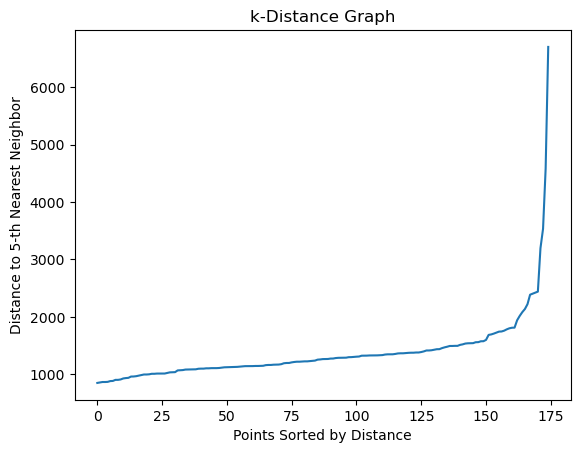

In [145]:
import numpy as np

k_test = 5  # Test with different values
nbrs = NearestNeighbors(n_neighbors=k_test).fit(lsoa[['x', 'y']])
distances, _ = nbrs.kneighbors(lsoa[['x', 'y']])

# Sort distances to the k-th neighbor
sorted_distances = np.sort(distances[:, k_test-1])

# Plot the sorted k-distances
plt.plot(sorted_distances)
plt.xlabel("Points Sorted by Distance")
plt.ylabel(f"Distance to {k_test}-th Nearest Neighbor")
plt.title("k-Distance Graph")
plt.show()

In [148]:
from sklearn.neighbors import NearestNeighbors

# Compute average distance to nearest 5 neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(lsoa[['x', 'y']])
distances, _ = nbrs.kneighbors(lsoa[['x', 'y']])
avg_dist = distances.mean(axis=1)

# Set adaptive k: more neighbors in sparse regions, fewer in dense regions
adaptive_k = np.round(1 + (avg_dist / avg_dist.max()) * 10).astype(int)

print("Adaptive k values (first 100):", adaptive_k[:100])


Adaptive k values (first 100): [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 3 2 2 3 3 2 2 3 3 3 3 3 3 2 3 2 2 2
 2 3 3 3 2 3 3 3 2 3 2 3 3 3 3 2 3 3 3 2 3 3 2 2 2 3 3 3 3 3 2 2 3 5 3 4 3
 3 3 4 3 4 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 3 2 3 3 3 3]


#### using k-NN 

In [ ]:
# reproject
lsoa = lsoa.to_crs(epsg=3857)
lines = lines.to_crs(epsg=3857)
combined_nodes = combined_nodes.to_crs(epsg=3857)   
greedy_gdf = greedy_gdf.to_crs(epsg=3857)



# Convert geo_code columns to strings for consistency
lsoa['geo_code'] = lsoa['geo_code'].astype(str)
lines['geo_code1'] = lines['geo_code1'].astype(str)
lines['geo_code2'] = lines['geo_code2'].astype(str)

# Compute coordinates
lsoa['x'] = lsoa.geometry.x
lsoa['y'] = lsoa.geometry.y
combined_nodes['x'] = combined_nodes.geometry.x
combined_nodes['y'] = combined_nodes.geometry.y

# k-NN setup
k = 5 # CHANGE
combined_coords = combined_nodes[['x', 'y']].values
lsoa_coords = lsoa[['x', 'y']].values

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(combined_coords)
distances, indices = nbrs.kneighbors(lsoa_coords)

# Build mapping dictionary (geo_code -> list of (osmid, normalized_weight))
mapping = {}
for i, row in enumerate(lsoa.itertuples()):
    lsoa_code = row.geo_code
    node_indices = indices[i]
    dists = distances[i]
    # Avoid division by zero by adding a small constant
    weights = 1 / (dists + 1e-6)
    normalised_weights = weights / weights.sum()
    node_ids = combined_nodes.iloc[node_indices]['osmid'].values
    mapping[lsoa_code] = list(zip(node_ids, normalised_weights))

# Debug: check mapping keys
if debug: 
    print("Mapping keys (first 10):", list(mapping.keys())[:10])
    print("Total LSOA mapping entries:", len(mapping))

# Generate flow records from desire lines
flow_records = []
for idx, row in lines.iterrows():
    origin_code = row['geo_code1']
    dest_code = row['geo_code2']
    demand = row['dutch_slc']

    # Debug: report missing mappings if any
    if debug:
        if origin_code not in mapping:
            print(f"Origin code {origin_code} not in mapping")
        if dest_code not in mapping:
            print(f"Destination code {dest_code} not in mapping")

    if origin_code in mapping and dest_code in mapping:
        origin_nodes = mapping[origin_code]
        dest_nodes = mapping[dest_code]
        total_weight_product = sum(w_o * w_d for (_, w_o) in origin_nodes for (_, w_d) in dest_nodes)
        for o_node, w_o in origin_nodes:
            for d_node, w_d in dest_nodes:
                flow_share = demand * (w_o * w_d) / total_weight_product
                node_pair = tuple(sorted((o_node, d_node)))
                flow_records.append({'osmid_pair': node_pair, 'flow': flow_share})

if debug:
    print("Number of flow records:", len(flow_records))

# Aggregate flows
flow_df = pd.DataFrame(flow_records)
if flow_df.empty:
    print("No flow records were generated. Check your mapping and geo_code consistency.")
else:
    total_flow = flow_df.groupby('osmid_pair')['flow'].sum().reset_index(name='total_flow')
    if debug:
        print(total_flow.head())

    # Merge with network data (greedy_gdf)
    greedy_gdf = greedy_gdf.copy()
    
    # Ensure osmid_pair is built as sorted tuples to match total_flow keys
    greedy_gdf['osmid_pair'] = greedy_gdf.apply(
        lambda row: tuple(sorted((int(row['start_osmid']), int(row['end_osmid'])))), axis=1
    )
    
    # Merge the flows
    greedy_gdf = greedy_gdf.merge(total_flow, on='osmid_pair', how='left')
    greedy_gdf['total_flow'] = greedy_gdf['total_flow'].fillna(0)
    if debug: 
        print(greedy_gdf[['osmid_pair', 'total_flow']].head())


lsoa = lsoa.to_crs(epsg=4326)
lines = lines.to_crs(epsg=4326)
combined_nodes = combined_nodes.to_crs(epsg=4326)   
greedy_gdf = greedy_gdf.to_crs(epsg=4326)


Mapping keys (first 10): ['E01008438', 'E01008437', 'E01008390', 'E01008301', 'E01008389', 'E01008426', 'E01008305', 'E01008427', 'E01008428', 'E01008425']
Total LSOA mapping entries: 175
Number of flow records: 87100
             osmid_pair  total_flow
0  (11134462, 11134462)   10.103854
1  (11134462, 29159836)    5.654948
2  (11134462, 29187496)   16.832832
3  (11134462, 29494338)   18.012507
4  (11134462, 30123995)   28.660801
                  osmid_pair  total_flow
0  (4140896891, 12091933082)   38.442697
1  (8254838993, 12091933082)   30.423594
2      (60150990, 252100827)   30.291667
3     (345643357, 776327170)   26.233243
4   (252203650, 11895667567)    8.139472


In [134]:
greedy_gdf= greedy_gdf.drop(columns=['total_flow_x', 'total_flow_y'])

### PCT Testing

#### Produce a network using routed PCT dutch scenario

In [ ]:

# Sort the GeoDataFrame by 'dutch_slc' descending - most potential first
sorted_rnet = rnet.sort_values('dutch_slc', ascending=False)
cumulative_lengths = sorted_rnet['length_m'].cumsum().values

G_pct_gdfs = []

# Track the maximum index reached to avoid reprocessing
max_idx = 0

for D in investment_levels:
    # Find the furthest index where cumulative length <= D
    idx = np.searchsorted(cumulative_lengths[max_idx:], D, side='right') + max_idx
    idx = min(idx, len(sorted_rnet))  # Ensure we don't exceed the dataframe
    
    # Select edges up to this index
    subset = sorted_rnet.iloc[:idx]
    G_pct_gdfs.append(subset)
    
    # Update max_idx to reflect edges already included
    max_idx = idx



### General Testing

In [ ]:
investment_levels = [5503.54106,
 369233.16903,
 372964.797]

In [ ]:
investment_levels

In [ ]:
## many combinations
random_edges = pd.Series(False, index=greedy_gdf.index)  
distance = 0.0 # needed for budget

Random_GT_abstracts = []
Random_GTs = []

# reset global variables
global_processed_pairs_random = set()
cumulative_GT_indices_random = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract randomly and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    # Calculate remaining budget for new edges
    remaining_budget = D - distance
    
    if remaining_budget > 0:
        unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
        if not unselected_edges.empty:
            shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
            cumulative_distances = shuffled_edges['distance'].cumsum()
            within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
            new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
            random_edges[new_indices] = True
            remaining_edges = (~random_edges).sum()
            print(f"Remaining edges to add: {remaining_edges}")
            if within_budget.any():
                distance += cumulative_distances[within_budget].iloc[-1]
    # save edges
    GT_abstract_gdf = greedy_gdf[random_edges].copy()
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    Random_GT_abstracts.append(GT_abstract_nx)
    poipairs = list(GT_abstract_nx.edges()) # store currently connected points for routing

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    
    routenodepairs = [(u, v) for u, v in poipairs]
   

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs_random or tuple(reversed(poipair)) in global_processed_pairs_random:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"with a path length of", shortest_path_length , "on path: ", best_path)
                    print("The exit points were:", exit_points_a)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices_random.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices_random)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    Random_GTs.append(GT)
        
    

    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    Random_GTs_igraph = [ig.Graph.from_networkx(gt) for gt in Random_GTs]
    Random_GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in Random_GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": random, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs_igraph, "GT_abstracts": Random_GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, random, ".pickle", weighting=weighting)

        


final_remaining = (~random_edges).sum()
print(f"Final remaining edges: {final_remaining}")


In [ ]:
%run -i functions.py

In [ ]:
len(previous_selected_edges)

In [ ]:
# def get_unused_edges(gdf, selected_edges):
#     def normalize_edge(row):
#         return tuple(sorted((row['start_osmid'], row['end_osmid'])))
#     return gdf[~gdf.apply(lambda row: normalize_edge(row) in selected_edges, axis=1)]

# adjusted_gdf, selected_edges, _, _ = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
# remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
# unused_edges_gdf = get_unused_edges(greedy_gdf, selected_edges)

# # Plotting the results
# ax = greedy_gdf.plot(color='lightgrey', linewidth=1, alpha=0.5)  # background context
# unused_edges_gdf.plot(ax=ax, color='red', linewidth=2)

# unused_edges_gdf.explore()

In [ ]:
ebc_ltn.type

In [ ]:
def adjust_triangulation_to_budget(triangulation_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges=None, ltn_node_pairs=None):
    """
    Adjust a given triangulation to fit within the specified budget D,
    ensuring that previously selected edges are always included.
    Only after all ltns are connected do we move to include the growth of other areas.
    """
    # make a graph
    G = nx.Graph()
    for _, row in triangulation_gdf.iterrows():
        G.add_edge(
            row['start_osmid'],
            row['end_osmid'],
            geometry=row['geometry'],
            distance=row['distance']
        )

    total_length = 0
    selected_edges = set(tuple(sorted(edge)) for edge in (previous_selected_edges or [])) # use tuple to ensure we don't double count edges

    # Include previously selected edges so that we aren't starting from stratch each loop through
    for u, v in selected_edges:
        if G.has_edge(u, v):
            total_length += G[u][v]['distance']

    # Track the ltns which are connected
    connected_ltn_pairs = set()

    # Track all other connected pairs
    connected_other_pairs = set()

    # Prune for ltn node pairs first
    for (node1, node2), centrality in ebc_ltn.items():
        if node1 in G.nodes and node2 in G.nodes:
            edges = shortest_paths_ltn.get((node1, node2), [])
            if edges:  # If a valid path exists
                # Calculate new edges and their length
                new_edges = [tuple(sorted((u, v))) for u, v in edges if tuple(sorted((u, v))) not in selected_edges]
                new_length = sum(G[min(u, v)][max(u, v)]['distance'] for u, v in new_edges)
                # Check if adding this path exceeds the budget D
                if total_length + new_length > D:
                    continue
                # Add the edges to selected_edges
                selected_edges.update(new_edges)
                total_length += new_length
                connected_ltn_pairs.add((node1, node2))

    
    # Check if all ltn node pairs are connected
    if set(ltn_node_pairs).issubset(connected_ltn_pairs):
        # Now move to all other connections (ltn to tess, tess to tess, tess to ltn etc)
        for (node1, node2), centrality in ebc_other.items():
            if node1 in G.nodes and node2 in G.nodes:
                edges = shortest_paths_other.get((node1, node2), [])
                if edges:  # If a valid path exists
                    new_edges = [tuple(sorted((u, v))) for u, v in edges if tuple(sorted((u, v))) not in selected_edges]
                    new_length = sum(G[min(u, v)][max(u, v)]['distance'] for u, v in new_edges)
                    # Check if adding this path exceeds the budget D
                    if total_length + new_length > D:
                        continue
                    # Add the edges to selected_edges
                    selected_edges.update(new_edges)
                    total_length += new_length
                    connected_other_pairs.add((node1, node2))
    # missing_pairs = [pair for pair in ltn_node_pairs if pair not in connected_ltn_pairs]


    # edges which aren't in a shortest path won't have been selected
    # we will add these last, as they are the least important
    unused_edges = []
    for _, row in triangulation_gdf.iterrows():
        e = tuple(sorted((row['start_osmid'], row['end_osmid'])))
        dist = row['distance']
        if e not in selected_edges:
            unused_edges.append((dist, e))
    unused_edges.sort(key=lambda x: x[0])
    for dist, edge in unused_edges:
        if total_length + dist <= D:
            selected_edges.add(edge)
            total_length += dist
        else:
            break

    # Build the adjusted GeoDataFrame
    lines = []
    distances = []
    start_osmids = []
    end_osmids = []


    for u, v in selected_edges:
        lines.append(G[u][v]['geometry'])
        distances.append(G[u][v]['distance'])
        start_osmids.append(u)
        end_osmids.append(v)

    adjusted_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_osmid': start_osmids,
        'end_osmid': end_osmids,
        'distance': distances,
    }, crs=triangulation_gdf.crs)

    return adjusted_gdf, selected_edges, connected_ltn_pairs, connected_other_pairs






In [ ]:
# ############# PLOT EVERY GT_ABSTRACT  if debug #############


# ## betwenness
# ## many combinations
# previous_selected_edges = set()

# GT_abstracts = []
# GTs = []

# global_processed_pairs = set()
# cumulative_GT_indices = set()


# for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
#     # make abstract greedy triangulation graph
#     GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
#     remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
#     if debug:
#         print(f"Remaining edges to add: {remaining_edges}")
    
#     GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
#     GT_abstracts.append(GT_abstract_nx)
#     if debug:
#         # Plot GT_abstract_gdf with a title indicating the number of meters used to invest at that level
#         ax = GT_abstract_gdf.plot()
#         ax.set_title(f"Investment level: {D} meters")
#         ax.set_title(f"Investment level: {D} meters, Number of edges: {len(GT_abstract_gdf)}")
#         plt.show()
    


In [ ]:
Test = GT_abstracts[2]
Test.edges(data=True)

In [ ]:
# # List to store total lengths of each graph in GT_abstracts
# total_lengths_abstracts = []

# for G in GT_abstracts:
#     # Calculate total edge length of the graph
#     lengths = nx.get_edge_attributes(G, 'weight')
#     total_length = sum(lengths.values())
#     total_lengths_abstracts.append(total_length)

# # Create a line plot
# plt.figure(figsize=(10, 6))
# plt.plot(total_lengths_abstracts, marker='o', linestyle='-')
# plt.title('Total Length of Abstract Graphs')
# plt.xlabel('Graph Index in GT_abstracts')
# plt.ylabel('Total Length (meters)')
# plt.grid(True)
# plt.show()

In [ ]:
# set investment max to a fully connected bicycle network, and interval to 1% incremental steps
points = np.linspace(0, total_distance, 101)
# Drop 0 as we don't need to consider the empty network
investment_levels = points[1:].tolist()

In [ ]:
test = list(GT_abstract_nx.edges())
test

In [ ]:
## betwenness
## many combinations
previous_selected_edges = set()

GT_abstracts = []
GT_abstracts_gdf = []
GTs = []
GTs_gdf = []



global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
    if debug:
        print(f"Remaining edges to add: {remaining_edges}")
    
    GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    # poipairs = connected_ltn_pairs | connected_other_pairs
    poipairs = list(GT_abstract_nx.edges())
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    GTs.append(GT)
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GTs_gdf.append(GT_edges)


    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    GTs_igraph = [ig.Graph.from_networkx(gt) for gt in GTs]
    GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs_igraph, "GT_abstracts": GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

        





In [ ]:
iteration = 0

ax = GTs_gdf[iteration].to_crs(epsg=3857).plot()
GT_abstracts_gdf[iteration].to_crs(epsg=3857).plot(ax=ax, color='red')

ltn_gdf.plot(ax=ax, color='red', markersize=10)
tess_gdf.plot(ax=ax, color='green', markersize=5)

In [ ]:
greedy_nx

# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(greedy_nx, weight='sp_lts_distance')

# Convert to GeoDataFrame
edges = []
for u, v, data in greedy_nx.edges(data=True):
    edge_data = {
        'start_osmid': u,
        'end_osmid': v,
        'geometry': data['geometry'],
        'betweenness_centrality': edge_betweenness[(u, v)]
    }
    edges.append(edge_data)

greedy_gdf_with_betweenness = gpd.GeoDataFrame(edges).set_crs(3857)

# Calculate the rank of betweenness centrality
greedy_gdf_with_betweenness['betweenness_rank'] = greedy_gdf_with_betweenness['betweenness_centrality'].rank(ascending=False).astype(int)

greedy_gdf_with_betweenness

In [ ]:
# Filter the top 20 rows based on betweenness_rank
top_20_betweenness = greedy_gdf_with_betweenness.nsmallest(20, 'betweenness_rank')

# Use .explore() to visualize the top 20 betweenness ranking
top_20_betweenness.explore(cmap='viridis', column='betweenness_rank', legend=True)

In [ ]:
greedy_gdf_with_betweenness.explore(cmap='viridis', column='betweenness_rank', legend=True)

In [ ]:
iteration = 50
m= GT_abstracts_gdf[iteration].to_crs(epsg=3857).explore(color='red')
neighbourhoods['Newcastle Upon Tyne'].explore(m=m, color='red', markersize=10)

In [ ]:

# Calculate total lengths for each graph in GTs
total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(10, 6))
plt.plot(total_lengths, marker='o', linestyle='-')
plt.xlabel('Graph Index')
plt.ylabel('Total Length (meters)')
plt.title('Total Length of Graphs in GTs')
plt.grid(True)
plt.show()

In [ ]:
investment_levels

In [ ]:

GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
GT_edges = GT_edges.to_crs(epsg=3857)
ax = GT_edges.plot()

GT_abs_nodes, GT_abs_edges = ox.graph_to_gdfs(GT_abs)
GT_abs_edges = GT_abs_edges.to_crs(epsg=3857)
GT_abs_edges.plot(ax=ax, color='red', linewidth=2)

ltn_gdf.plot(ax=ax, color='red', markersize=10)
tess_gdf.plot(ax=ax, color='green', markersize=5)
ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")

In [ ]:
# gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
# G_biketrack = ox_gpkg_to_graph(gpkg_path)
# G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))

In [ ]:
# import folium
# import geopandas as gpd

# # Assuming G_biketrack_edges and exit_points_3857 are already defined as GeoDataFrames

# # Ensure both GeoDataFrames are in the same CRS (e.g., EPSG:4326 for folium compatibility)
# if G_biketrack_edges.crs != 'EPSG:4326':
#     G_biketrack_edges = G_biketrack_edges.to_crs('EPSG:4326')
# if exit_points_3857.crs != 'EPSG:4326':
#     exit_points_3857 = exit_points_3857.to_crs('EPSG:4326')

# # Create a folium map centered on the first point of G_biketrack_edges
# map_center = [G_biketrack_edges.geometry.centroid.y.iloc[0], G_biketrack_edges.geometry.centroid.x.iloc[0]]
# m = folium.Map(location=map_center, zoom_start=14)

# # Add G_biketrack_edges to the map as a line layer
# for _, row in G_biketrack_edges.iterrows():
#     folium.PolyLine(
#         locations=[(point[1], point[0]) for point in row.geometry.coords],  # Swap lat/lon for folium
#         color='blue',
#         weight=2,
#         opacity=0.7
#     ).add_to(m)

# # Add exit_points_3857 to the map as a point layer
# for _, row in exit_points_3857.iterrows():
#     folium.CircleMarker(
#         location=(row.geometry.y, row.geometry.x),  # Swap lat/lon for folium
#         radius=5,
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.7
#     ).add_to(m)

# # Display the map
# m

In [ ]:
# ## investigate if exit points match with neighbourhoods?

# # Set up a larger figure
# fig, ax = plt.subplots(figsize=(20, 14))  # Adjust the width and height as needed


# # Add G_weighted edges
# G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
# G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)  # Ensure CRS matches
# G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder = 0)  # Light grey with thin linewidth

# # Add bike track edges
# G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
# G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
# G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 2)  # Light grey with thin linewidth


# # Plot the main graph and layers
# GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
# GT_edges = GT_edges.to_crs(epsg=3857)
# GT_edges.plot(ax=ax, color='orange', zorder = 1)

# # plot exit points
# exit_points_3857 = exit_points.to_crs(epsg=3857)
# exit_points_3857.plot(ax=ax, color='red', markersize=3)




# # Remove x and y axis labels and ticks
# ax.axis('off')  # This removes the entire axis, including labels and ticks

# # Enhance plot aesthetics
# ax.set_title(f"Meters of investment: {D/10}")
# ax.legend(loc="upper left")

# # Show the plot
# plt.show()


## Analysis and Plots

This section of code creates the analysis and plots. We are measuring the success 

In [ ]:
# Define the list of investment levels
#investment_levels = list(np.arange(5000, 250000, 5000))

# Loop through every graph in GTs
for idx, G in enumerate(GTs):

    # Skip empty graphs or graphs with no edges
    if len(G.edges()) == 0:
        print(f"Graph {idx + 1} has no edges, skipping plot.")
        continue
    
    # Get the corresponding investment level for this graph
    D = investment_levels[idx] if idx < len(investment_levels) else investment_levels[-1]
    
    # Set up a larger figure
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed

    # Add G_weighted edges
    G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
    G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)  # Ensure CRS matches
    G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder=0)  # Light grey with thin linewidth

    # Add bike track edges
    #G_biketrack = {}
    #G_biketrack[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
    #G_biketrack[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    #G_biketrack = copy.deepcopy(G_biketrack[placeid])
    G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
    G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
    G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder=1)  # Light grey with thin linewidth

    # Plot the main graph and layers
    GT_nodes, GT_edges = ox.graph_to_gdfs(G)
    GT_edges = GT_edges.to_crs(epsg=3857)
    GT_edges.plot(ax=ax, color='orange')
    
    ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=4)
    tess_gdf.plot(ax=ax, color='green', markersize=5, zorder=3)

    placename = "Newcastle Upon Tyne"  # Replace with the key of the neighbourhood you want to plot
    if placename in neighbourhoods:
        neighbourhood_gdf = neighbourhoods[placename]
        neighbourhood_gdf = neighbourhood_gdf.to_crs(epsg=3857)  # Ensure the CRS matches
        neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, label=f"Neighbourhood: {placename}", zorder=2)

    # Remove x and y axis labels and ticks
    ax.axis('off')  # This removes the entire axis, including labels and ticks

    # Enhance plot aesthetics
    ax.set_title(f"Meters of investment: {D}")  # Title with the dynamic value of D
    ax.legend(loc="upper left")

   
    plt.show()




In [ ]:

# Set up a larger figure
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed


# Add G_weighted edges
G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)  # Ensure CRS matches
G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder = 0)  # Light grey with thin linewidth

# Add bike track edges
#G_biketrack = {}
#G_biketrack[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
#G_biketrack[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
#G_biketrack = copy.deepcopy(G_biketrack[placeid])
G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 1)  # Light grey with thin linewidth


# Plot the main graph and layers
GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
GT_edges = GT_edges.to_crs(epsg=3857)
GT_edges.plot(ax=ax, color='orange')
ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=4)
tess_gdf.plot(ax=ax, color='green', markersize=5, zorder = 3)

placename = "Newcastle Upon Tyne"  # Replace with the key of the neighbourhood you want to plot
if placename in neighbourhoods:
    neighbourhood_gdf = neighbourhoods[placename]
    neighbourhood_gdf = neighbourhood_gdf.to_crs(epsg=3857)  # Ensure the CRS matches
    neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, label=f"Neighbourhood: {placename}", zorder=2)


# Remove x and y axis labels and ticks
ax.axis('off')  # This removes the entire axis, including labels and ticks

# Enhance plot aesthetics
ax.set_title(f"Meters of investment: {D/10}")
ax.legend(loc="upper left")

# Show the plot
plt.show()


In [ ]:
last_item = GTs[0]
last_item


# Set up a larger figure
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed


# Add G_weighted edges
G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)  # Ensure CRS matches
G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder = 0)  # Light grey with thin linewidth

# Add bike track edges
#G_biketrack = {}
#G_biketrack[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
#G_biketrack[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
#G_biketrack = copy.deepcopy(G_biketrack[placeid])
G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 1)  # Light grey with thin linewidth


# Plot the main graph and layers
GT_nodes, GT_edges = ox.graph_to_gdfs(last_item)
GT_edges = GT_edges.to_crs(epsg=3857)
GT_edges.plot(ax=ax, color='orange')
ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=4)
tess_gdf.plot(ax=ax, color='green', markersize=5, zorder = 3)

placename = "Newcastle Upon Tyne"  # Replace with the key of the neighbourhood you want to plot
if placename in neighbourhoods:
    neighbourhood_gdf = neighbourhoods[placename]
    neighbourhood_gdf = neighbourhood_gdf.to_crs(epsg=3857)  # Ensure the CRS matches
    neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, label=f"Neighbourhood: {placename}", zorder=2)


# Remove x and y axis labels and ticks
ax.axis('off')  # This removes the entire axis, including labels and ticks

# Enhance plot aesthetics
ax.set_title(f"Meters of investment: {D/10}")
ax.legend(loc="upper left")

# Show the plot
plt.show()


Total size

In [ ]:
total_lengths = []
for G in GTs:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

In [ ]:

# Plot the total lengths for GTs
total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

plt.figure(figsize=(5, 5))
plt.plot(total_lengths, linestyle='-', color='orange', label='GTs')

# Plot the total lengths for Random_GTs
random_total_lengths = []
for G in Random_GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    random_total_lengths.append(total_length)

plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random_GTs')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Directness (Directness=Total Sum of Network Distances/Total Sum of Euclidean Distances​)

In [ ]:
# Function to calculate total Euclidean distance
def calculate_total_euclidean_distance(G, debug=False):
    if len(G.edges()) == 0:  # Check if the graph is empty
        return 0
    total_distance = 0
    # Iterate over all edges in the graph
    for u, v, data in G.edges(data=True):
        # Calculate great-circle distance between nodes u and v
        distance = ox.distance.great_circle(G.nodes[u]['y'], G.nodes[u]['x'], G.nodes[v]['y'], G.nodes[v]['x'])
        total_distance += distance
    if debug:
        print(f"Total great-circle distance between all connected node pairs: {total_distance}")
    return total_distance

# Function to calculate total network distance
def calculate_total_network_distance(G, debug=False):
    """
    Calculate the total network distance (sum of edge lengths) in the graph G.
    """
    if len(G.edges()) == 0:  # Check if the graph is empty
        return 0
    
    total_network_distance = 0
    
    # Iterate over all edges in the graph
    for u, v, data in G.edges(data=True):
        # Add the edge length to the total network distance
        total_network_distance += data.get('length', 0)
    
    if debug:
        print(f"Total network distance between all connected node pairs: {total_network_distance}")
    
    return total_network_distance

# Function to calculate directness
def calculate_directness(total_euclidean_distance, total_network_distance):
    if total_network_distance == 0:  # Avoid division by zero
        return 0
    if debug:
        print (total_euclidean_distance, total_network_distance)
    return abs(total_euclidean_distance / total_network_distance)

# Calculate directness values for each graph in GTs
directness_values = []
for G in GTs:
    total_euclidean = calculate_total_euclidean_distance(G)
    total_network = calculate_total_network_distance(G)
    directness = calculate_directness(total_euclidean, total_network)
    directness_values.append(directness)



# Plot the directness values
plt.figure(figsize=(4, 5))  # Narrower and taller dimensions
plt.plot(directness_values, linestyle='-', color='r')  # Use red color for directness
plt.xlabel('Investment Iteration')
plt.ylabel('Directness')
plt.title('Directness of Invested Cycle Network')

plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

In [ ]:


# Normalise the directness values to the range [0, 1]
min_directness = min(directness_values)
max_directness = max(directness_values)

# Avoid division by zero if all values are the same
if max_directness != min_directness:
    normalized_directness_values = [(d - min_directness) / (max_directness - min_directness) for d in directness_values]
else:
    # If all values are the same, set everything to 0 (or 1 if you prefer)
    normalized_directness_values = [0] * len(directness_values)

# Now plot the normalized values
plt.figure(figsize=(4, 5))  # Narrower and taller dimensions
plt.plot(normalized_directness_values, linestyle='-', color='darkturquoise')  # Use red color for directness
plt.xlabel('Investment Iteration')
plt.ylabel('Directness')
plt.title('Directness of Invested Cycle Network')

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Optionally, set custom ticks if you want them spaced evenly
plt.yticks([i * 0.2 for i in range(6)])

plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()


### Size of bike network

In [ ]:
# List to store total lengths of each composed graph
total_lengths = []

for G in GTs:
    # Compose the current graph with the bike track graph
    merged = nx.compose(G, G_biketrack)
    
    # Calculate total edge length of the merged graph
    stats = ox.basic_stats(merged)
    total_length = stats['edge_length_total']
    
    total_lengths.append(total_length)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(total_lengths, marker='o', linestyle='-')
plt.title('Total Length of Cycle Network')
plt.xlabel('Graph Index in GTs')
plt.ylabel('Total Length (meters)')
plt.grid(True)
plt.show()

Size with and without LTN streets

In [ ]:

# Extract lengths of all edges in G_biketrack
lengths_biketrack = nx.get_edge_attributes(G_biketrack, 'length')
total_length_biketrack = sum(lengths_biketrack.values())

# Extract lengths of all edges in G_biketrack_no_ltn
lengths_biketrack_no_ltn = nx.get_edge_attributes(G_biketrack_no_ltn, 'length')
total_length_biketrack_no_ltn = sum(lengths_biketrack_no_ltn.values())

# Calculate the difference
difference_in_length = total_length_biketrack - total_length_biketrack_no_ltn

print(f"Total length of G_biketrack: {total_length_biketrack}")
print(f"Total length of G_biketrack_no_ltn: {total_length_biketrack_no_ltn}")
print(f"Difference in total length: {difference_in_length}")

### Length of LCC

In [ ]:
total_lengths_lcc = []  # List to store lengths of largest connected components

for G in GTs:
    # Compose graphs and find largest connected component
    merged = nx.compose(G, G_biketrack)
    
    # Get weakly connected components (works for both directed/undirected graphs)
    components = list(nx.weakly_connected_components(merged))
    
    if not components:
        total_length = 0.0  # Handle empty graph case
    else:
        # Find largest component by node count
        largest_component_nodes = max(components, key=len)
        largest_component = merged.subgraph(largest_component_nodes)
        
        # Calculate total edge length in the largest component
        total_length = sum(data['length'] for u, v, data in largest_component.edges(data=True))
    
    total_lengths_lcc.append(total_length)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(total_lengths_lcc, marker='o', linestyle='-', color='darkgreen')
plt.title('Total Length of Largest Connected Component')
plt.xlabel('Graph Index in GTs')
plt.ylabel('Total Length (meters)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
total_lengths_lcc = []  # List to store lengths of largest connected components for GTs
random_total_lengths_lcc = []  # List to store lengths of largest connected components for Random_GTs

# Calculate total lengths of largest connected components for GTs
for G in GTs:
    # Compose graphs and find largest connected component
    merged = nx.compose(G, G_biketrack)
    
    # Get weakly connected components (works for both directed/undirected graphs)
    components = list(nx.weakly_connected_components(merged))
    
    if not components:
        total_length = 0.0  # Handle empty graph case
    else:
        # Find largest component by node count
        largest_component_nodes = max(components, key=len)
        largest_component = merged.subgraph(largest_component_nodes)
        
        # Calculate total edge length in the largest component
        total_length = sum(data['length'] for u, v, data in largest_component.edges(data=True))
    
    total_lengths_lcc.append(total_length)

# Calculate total lengths of largest connected components for Random_GTs
for G in Random_GTs:
    # Compose graphs and find largest connected component
    merged = nx.compose(G, G_biketrack)
    
    # Get weakly connected components (works for both directed/undirected graphs)
    components = list(nx.weakly_connected_components(merged))
    
    if not components:
        total_length = 0.0  # Handle empty graph case
    else:
        # Find largest component by node count
        largest_component_nodes = max(components, key=len)
        largest_component = merged.subgraph(largest_component_nodes)
        
        # Calculate total edge length in the largest component
        total_length = sum(data['length'] for u, v, data in largest_component.edges(data=True))
    
    random_total_lengths_lcc.append(total_length)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(total_lengths_lcc, marker='o', linestyle='-', color='darkgreen', label='GTs')
plt.plot(random_total_lengths_lcc, marker='o', linestyle='--', color='blue', label='Random_GTs')
plt.title('Total Length of Largest Connected Component')
plt.xlabel('Graph Index')
plt.ylabel('Total Length (meters)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Size of LCC (number of components)

In [ ]:
def calculate_lcc_size(G):
    """
    Calculate the size (total length) of the largest strongly connected component (LCC) in the directed graph G.
    """
    # Find the largest strongly connected component
    lcc = max(nx.strongly_connected_components(G), key=len)  # For directed graphs
    
    # Create a subgraph of the largest strongly connected component
    lcc_subgraph = G.subgraph(lcc)
    
    # Calculate the total length of the LCC
    total_length = sum(data.get('length', 0) for _, _, data in lcc_subgraph.edges(data=True))
    
    return total_length

def calculate_and_plot_lcc_sizes(GTs):
    """
    Calculate the size of the largest connected component for each graph in GTs and plot the results.
    """
    lcc_sizes = []
    
    # Calculate LCC size for each graph
    for G in GTs:
        lcc_size = calculate_lcc_size(G)
        lcc_sizes.append(lcc_size)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(lcc_sizes, marker='o', linestyle='-', color='b')
    plt.title("Size of Largest Connected Component (LCC) for Each Graph")
    plt.xlabel("Graph Index")
    plt.ylabel("LCC Size (Total Length)")
    plt.grid(True)
    plt.show()
    
    return lcc_sizes


lcc_sizes = calculate_and_plot_lcc_sizes(GTs)


### Number of componets

In [ ]:
def count_components(G):
    """
    Count the number of strongly connected components in the directed graph G.
    """
    # Count the number of strongly connected components
    num_components = nx.number_strongly_connected_components(G)
    return num_components

def calculate_and_plot_num_components(GTs):
    """
    Count the number of strongly connected components for each graph in GTs and plot the results.
    """
    num_components_list = []
    
    # Count the number of components for each graph
    for G in GTs:
        num_components = count_components(G)
        num_components_list.append(num_components)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(num_components_list, marker='o', linestyle='-', color='r')
    plt.title("Number of Strongly Connected Components for Each Investment Level")
    plt.xlabel("Graph Index")
    plt.ylabel("Number of Components")
    plt.grid(True)
    plt.show()
    
    return num_components_list

num_components_list = calculate_and_plot_num_components(GTs)

### Coverage

In [ ]:
intersection_percentages = []

for G in GTs:
    if len(G.edges()) == 0:
        intersection_percentages.append(0)
        continue

    # Convert networkx graph to GeoDataFrames
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Reproject to EPSG:3857
    gdf_edges = gdf_edges.to_crs(epsg=3857)

    # Create a buffer around edges
    gdf_buffer = gdf_edges.geometry.buffer(buffer_walk)
    gdf_buffer_union = gdf_buffer.unary_union  # Ensure a single geometry

    # Ensure G_weighted_edges is a single geometry
    weighted_edges_union = G_weighted_edges.geometry.unary_union

    # Compute intersection
    intersection = gdf_buffer_union.intersection(weighted_edges_union)

    # If working with LineStrings, use length instead of area
    intersection_length = intersection.length
    total_length = weighted_edges_union.length
    percent_intersected = (intersection_length / total_length) * 100 if total_length != 0 else 0

    # Store result
    intersection_percentages.append(percent_intersected)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(GTs)), intersection_percentages, marker='o', linestyle='-')
plt.xlabel("Graph Index")
plt.ylabel("Percentage Intersected")
plt.title("Intersection Percentage of G_weighted_edges by Graph Buffer")
plt.grid()
plt.show()

In [ ]:

for i, G in enumerate(GTs):
    if len(G.edges()) == 0:
        continue  # Skip empty graphs

    # Convert networkx graph to GeoDataFrames
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Reproject to EPSG:3857
    gdf_edges = gdf_edges.to_crs(epsg=3857)

    # Create a single unified buffer
    gdf_buffer_union = gdf_edges.geometry.buffer(buffer_walk).unary_union

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))
    G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder=0)
    G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 1)  
    neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, label=f"Neighbourhood: {placename}", zorder=2)

    # Plot the unified buffer as a single shape
    gpd.GeoSeries(gdf_buffer_union).plot(ax=ax, color='crimson', alpha=0.7, edgecolor='black', zorder=3)

    # Plot G edges on top
    gdf_edges.plot(ax=ax, color='orange', linewidth=1, zorder=4)

    ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=5)
    tess_gdf.plot(ax=ax, color='green', markersize=5, zorder = 6)

    ax.set_title(f"Graph {i} with Unified Buffer and Weighted Edges")
    plt.show()


In [ ]:
place_name = "Newcastle upon Tyne, United Kingdom"
boundary = ox.geocoder.geocode_to_gdf(place_name)
boundary.to_crs(epsg=3857, inplace=True)

coverage_percentages = []

# Ensure boundary is in EPSG:3857 (Web Mercator) for consistent area calculation
boundary = boundary.to_crs(epsg=3857)

for G in GTs:
    if len(G.edges()) == 0:
        coverage_percentages.append(0)
        continue

    # Convert networkx graph to GeoDataFrames
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Reproject to EPSG:3857 (if not already)
    gdf_edges = gdf_edges.to_crs(epsg=3857)

    # Create a buffer around edges
    gdf_buffer = gdf_edges.geometry.buffer(buffer_walk)
    gdf_buffer_union = gdf_buffer.unary_union  # Ensure a single geometry

    # Compute the intersection between buffer and study area (boundary)
    intersection = gdf_buffer_union.intersection(boundary.geometry.iloc[0])

    # Calculate areas
    intersection_area = intersection.area
    total_area = boundary.geometry.iloc[0].area

    # Calculate percentage of the study area covered by the buffer
    percent_covered = (intersection_area / total_area) * 100 if total_area != 0 else 0

    # Store result
    coverage_percentages.append(percent_covered)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(GTs)), coverage_percentages, marker='o', linestyle='-')
plt.xlabel("Graph Index")
plt.ylabel("Percentage Covered (by Area)")
plt.title("Area Coverage of Buffers by Graph within Study Area")
plt.grid()
plt.show()


### Seed points Coverage

Percentage of LTNs connected then percentage of all connected

In [ ]:
def count_covered_ltns(G, polygons, buffer_distance=50):
    # Check if the graph has edges
    if len(G.edges) == 0:
        return 0

    # Reproject the graph to Web Mercator (EPSG:3857)
    G_proj = ox.project_graph(G, to_crs="EPSG:3857")

    # Convert the projected graph to GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)

    # Reproject the points to Web Mercator (EPSG:3857)
    points_proj = polygons.to_crs("EPSG:3857")

    # Create a buffer around the graph's edges (in meters)
    buffered_edges = edges.geometry.buffer(buffer_distance)

    # Union all buffered geometries to create a single coverage area
    coverage_area = unary_union(buffered_edges)

    # Check if points are within the coverage area
    points_within = points_proj[points_proj.geometry.intersects(coverage_area)]

    # Return the count of covered points
    return len(points_within)

# Store the results in a list
covered_counts = []
# Iterate over each graph in GTs and count covered ltn_nodes
for i, G in enumerate(GTs):
    covered_count = count_covered_ltns(G, neighbourhood_gdf)
    covered_counts.append(covered_count)

# Plot the results as a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(GTs)), covered_counts, marker='o', linestyle='-', color='skyblue', label='Covered LTNs')
plt.xlabel('Graph Index')
plt.ylabel('Number of Covered LTNs')
plt.title('Number of LTNs Covered by Each Graph')
plt.xticks(range(len(GTs)), labels=[f'Graph {i}' for i in range(len(GTs))])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def count_covered_ltns(G, polygons, buffer_distance=50):
    # Check if the graph has edges
    if len(G.edges) == 0:
        return 0

    # Reproject the graph to Web Mercator (EPSG:3857)
    G_proj = ox.project_graph(G, to_crs="EPSG:3857")

    # Convert the projected graph to GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)

    # Reproject the polygons to Web Mercator (EPSG:3857)
    polygons_proj = polygons.to_crs("EPSG:3857")

    # Create a buffer around the graph's edges (in meters)
    buffered_edges = edges.geometry.buffer(buffer_distance)
    
    # Union all buffered geometries to create a single coverage area
    coverage_area = unary_union(buffered_edges)

    # Check if polygons intersect the coverage area
    polygons_within = polygons_proj[polygons_proj.geometry.intersects(coverage_area)]

    # Return the count of covered polygons
    return len(polygons_within)

def count_covered_tess_points(G, points, buffer_distance=50):
    # Check if the graph has edges
    if len(G.edges) == 0:
        return 0

    # Reproject the graph to Web Mercator (EPSG:3857)
    G_proj = ox.project_graph(G, to_crs="EPSG:3857")

    # Convert the projected graph to GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)

    # Reproject the points to Web Mercator (EPSG:3857)
    points_proj = points.to_crs("EPSG:3857")

    # Create a buffer around the graph's edges (in meters)
    buffered_edges = edges.geometry.buffer(buffer_distance)
    
    # Union all buffered geometries to create a single coverage area
    coverage_area = unary_union(buffered_edges)

    # Check if points are within the coverage area
    points_within = points_proj[points_proj.geometry.within(coverage_area)]

    # Return the count of covered points
    return len(points_within)

# Store the results in lists
covered_ltn_counts = []
covered_tess_counts = []

# Iterate over each graph in GTs and count covered LTNs and tess points
for i, G in enumerate(GTs):
    ltn_count = count_covered_ltns(G, neighbourhood_gdf)
    tess_count = count_covered_tess_points(G, tess_nodes)
    covered_ltn_counts.append(ltn_count)
    covered_tess_counts.append(tess_count)

# Plot the results as a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(GTs)), covered_ltn_counts, marker='o', linestyle='-', color='skyblue', label='Covered LTNs')
plt.plot(range(len(GTs)), covered_tess_counts, marker='s', linestyle='--', color='orange', label='Covered Tessellation Based Points')  # Changed legend label
plt.xlabel('Investment Iteration')  # Changed x-axis label
plt.ylabel('Number of Connected Seed Points')
plt.title('Coverage of Seed Points by Grown Network')  # Updated title
# Only label every 2nd tick
xticks_labels = [str(i + 1) for i in range(len(GTs))]
plt.xticks(range(0, len(GTs), 2), labels=xticks_labels[::2])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
# Combine tess_points and neighbourhood_gdf into one GeoDataFrame
seed_points_gdf = pd.concat([tess_nodes.to_crs(3857), neighbourhood_gdf], ignore_index=True)

# Ensure the combined GeoDataFrame has the same CRS
seed_points_gdf = seed_points_gdf.to_crs(epsg=4326)  # Assuming both input GeoDataFrames are in EPSG:4326

# Function to count covered points
def count_covered_seed_points(G, points, buffer_distance=50):
    # Check if the graph has edges
    if len(G.edges) == 0:
        return 0

    # Reproject the graph to Web Mercator (EPSG:3857)
    G_proj = ox.project_graph(G, to_crs="EPSG:3857")

    # Convert the projected graph to GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)

    # Reproject the points to Web Mercator (EPSG:3857)
    points_proj = points.to_crs("EPSG:3857")

    # Create a buffer around the graph's edges (in meters)
    buffered_edges = edges.geometry.buffer(buffer_distance)
    
    # Union all buffered geometries to create a single coverage area
    coverage_area = unary_union(buffered_edges)

    # Check if points are within the coverage area
    points_within = points_proj[points_proj.geometry.intersects(coverage_area)]

    # Return the count of covered points
    return len(points_within)

# Store the results in a list
covered_seed_counts = []

# Iterate over each graph in GTs and count covered seed points
for i, G in enumerate(GTs):
    seed_count = count_covered_seed_points(G, seed_points_gdf)
    covered_seed_counts.append(seed_count)

# Plot the results as a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(GTs)), covered_seed_counts, marker='o', linestyle='-', color='green', label='Covered Seed Points')
plt.xlabel('Graph Index')
plt.ylabel('Number of Covered Seed Points')
plt.title('Coverage of Seed Points by Each Graph')
plt.xticks(range(len(GTs)), labels=[f'Graph {i}' for i in range(len(GTs))])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Distance gained

Find the distance gained over the previous network. 

In [ ]:
# Preprocess G_biketrack's edges and their lengths
biketrack_edges = [
    (u, v, key, data['length'])
    for u, v, key, data in G_biketrack.edges(keys=True, data=True)
]

# Calculate the gained length for each G in GTs
gains = []
for G in GTs:
    # Collect edge identifiers (u, v, key) present in the current G
    current_edges = {(u, v, key) for u, v, key in G.edges(keys=True)}
    # Sum lengths of edges in G_biketrack not found in G
    gain = sum(
        length
        for u, v, key, length in biketrack_edges
        if (u, v, key) not in current_edges
    )
    gains.append(gain)

In [ ]:
plt.plot(gains)

In [ ]:

# Assume GTs is a list of directed graphs and G_biketrack is the existing cycling network graph
lcc_sizes = []

for G in GTs:
    # Combine G with the existing cycling network
    G_combined = nx.compose(G, G_biketrack)

    print(len(G))
    print(len(G_biketrack))
    print(len(G_combined))  
    
    # Find strongly connected components
    if len(G_combined.nodes) > 0:  # Only proceed if the graph is not empty
        # Find strongly connected components
        sccs = nx.strongly_connected_components(G_combined)
        largest_scc = max(sccs, key=len)
        # Store the size of the largest strongly connected component
        lcc_sizes.append(len(largest_scc))
    else:
        lcc_sizes.append(0)  # If the graph is empty, append 0

print(lcc_sizes)  # This will give the new largest strongly connected component sizes for each G in GTs


### Overlap

In [ ]:
import networkx as nx
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt

def calculate_overlap(graph, biketrack_edges, buffer_distance=10):
    """
    Calculate the overlap between a graph and a bike track graph.
    
    Parameters:
        graph (networkx.Graph): The graph to compare.
        biketrack_edges (gpd.GeoDataFrame): The edges of the bike track graph as a GeoDataFrame.
        buffer_distance (float): Buffer distance (in meters) to capture nearby edges.
    
    Returns:
        overlap_length (float): Total length of overlapping edges.
    """
    if len(graph.edges()) == 0:
        return 0  # Handle empty graphs

    # Ensure edge lengths exist
    graph = ox.distance.add_edge_lengths(graph)

    # Convert the graph to a GeoDataFrame of edges
    graph_edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

    # Ensure the 'length' column exists
    if 'length' not in graph_edges.columns:
        graph_edges['length'] = graph_edges.geometry.length  # Compute if missing

    # Ensure both GeoDataFrames use Web Mercator (meters)
    graph_edges = graph_edges.to_crs(epsg=3857)
    biketrack_edges = biketrack_edges.to_crs(epsg=3857)

    # Buffer the bike track edges
    biketrack_buffered = biketrack_edges.copy()
    biketrack_buffered['geometry'] = biketrack_buffered.geometry.buffer(buffer_distance)

    # Perform a spatial join to find overlapping edges
    overlapping_edges = gpd.sjoin(graph_edges, biketrack_buffered, how='inner', predicate='intersects')

    # Calculate the total length of overlapping edges
    overlap_length = overlapping_edges['length'].sum() if not overlapping_edges.empty else 0

    return overlap_length

def calculate_and_plot_overlaps(GTs, G_biketrack_edges, buffer_distance=10):
    """
    Calculate the overlap between each graph in GTs and G_biketrack_edges, and plot the results.
    
    Parameters:
        GTs (list): List of graphs to compare.
        G_biketrack_edges (gpd.GeoDataFrame): Edges of the bike track graph as a GeoDataFrame.
        buffer_distance (float): Buffer distance (in meters) to capture nearby edges.
    """
    overlap_lengths = []
    
    # Ensure biketrack edges are in Web Mercator before looping
    G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)

    # Calculate overlap for each graph in GTs
    for G in GTs:
        overlap_length = calculate_overlap(G, G_biketrack_edges, buffer_distance)
        overlap_lengths.append(overlap_length)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(overlap_lengths, marker='o', linestyle='-', color='g')
    plt.title("Overlap with Bike Track for Each Graph")
    plt.xlabel("Graph Index")
    plt.ylabel("Overlap Length (meters)")
    plt.grid(True)
    plt.show()
    
    return overlap_lengths

# Call the function
overlap_lengths = calculate_and_plot_overlaps(GTs, G_biketrack_edges, buffer_distance=10)


In [ ]:
overlap_lengths = calculate_and_plot_overlaps(GTs, G_biketrack_edges, buffer_distance=10)

### Save gifs

In [ ]:
import matplotlib.animation as animation



gif_path = r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth_external\videos\newcastle\investment_animation.gif"

# Set up a figure for animation
fig, ax = plt.subplots(figsize=(12, 8))

def update(idx):
    """Update function for each frame in the animation."""
    ax.clear()  # Clear previous frame

    G = GTs[idx]

    # Skip empty graphs
    if len(G.edges()) == 0:
        print(f"Graph {idx + 1} has no edges, skipping plot.")
        return
    
    # Get investment level
    D = investment_levels[idx] if idx < len(investment_levels) else investment_levels[-1]

    # Add G_weighted edges
    G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
    G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)
    G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder=0)

    # Add bike track edges
    G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
    G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
    G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder=1)

    # Plot main graph
    GT_nodes, GT_edges = ox.graph_to_gdfs(G)
    GT_edges = GT_edges.to_crs(epsg=3857)
    GT_edges.plot(ax=ax, color='orange')

    # Plot additional layers
    ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=4)
    tess_gdf.plot(ax=ax, color='green', markersize=5, zorder=3)

    # Plot the neighbourhood
    placename = "Newcastle Upon Tyne"
    if placename in neighbourhoods:
        neighbourhood_gdf = neighbourhoods[placename].to_crs(epsg=3857)
        neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, zorder=2)

    # Remove axis and set title
    ax.axis('off')
    ax.set_title(f"Meters of investment: {D/10}")

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(GTs), repeat=False)

# Save the animation as a GIF using PillowWriter
ani.save(gif_path, writer=animation.PillowWriter(fps=6))

print(f"GIF saved to: {gif_path}")

In [ ]:
breakpoint()

# this is the end of the useful code. all other parts are for testing only 

In [ ]:
def adjust_triangulation_to_budget(triangulation_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges=None, ltn_node_pairs=None):
    """
    Adjust a given triangulation to fit within the specified budget D,
    ensuring that previously selected edges are always included.
    Only after all ltns are connected do we move to include the growth of other areas.
    """
    # make a graph
    G = nx.Graph()
    for _, row in triangulation_gdf.iterrows():
        G.add_edge(
            row['start_osmid'],
            row['end_osmid'],
            geometry=row['geometry'],
            weight=row['distance']
        )

    # Calculate edge betweenness centrality
    bc = nx.edge_betweenness_centrality(G, weight='weight', normalized=True)
    for (u, v), centrality in bc.items():
        G[u][v]['ebc'] = centrality

    total_length = 0
    selected_edges = set(previous_selected_edges or [])

    # Include previously selected edges so that we aren't starting from stratch each loop through
    for u, v in selected_edges:
        if G.has_edge(u, v):
            total_length += G[u][v]['weight']

    # Track the ltns which are connected
    connected_ltn_pairs = set()

    # Track all other connected pairs
    connected_other_pairs = set()

    # Prune for ltn node pairs first
    for (node1, node2), centrality in ebc_ltn.items():
        if node1 in G.nodes and node2 in G.nodes:
            edges = shortest_paths_ltn.get((node1, node2), [])
            if edges:  # If a valid path exists
                path_length = sum(G[u][v]['weight'] for u, v in edges)
                # Check if adding this path exceeds the budget D
                if total_length + path_length > D:
                    continue
                # Add the edges to selected_edges
                for u, v in edges:
                    selected_edges.add((u, v))
                total_length += path_length
                connected_ltn_pairs.add((node1, node2))  # Mark the pair as connected

    
    # Check if all ltn node pairs are connected
    if set(ltn_node_pairs).issubset(connected_ltn_pairs):
        # Now move to all other connections (ltn to tess, tess to tess, tess to ltn etc)
        for (node1, node2), centrality in ebc_other.items():
            if node1 in G.nodes and node2 in G.nodes:
                edges = shortest_paths_other.get((node1, node2), [])
                if edges:  # If a valid path exists
                    path_length = sum(G[u][v]['weight'] for u, v in edges)
                    # Check if adding this path exceeds the budget D
                    if total_length + path_length > D:
                        continue
                    # Add the edges to selected_edges
                    for u, v in edges:
                        selected_edges.add((u, v))
                    total_length += path_length
                    connected_other_pairs.add((node1, node2))
    # missing_pairs = [pair for pair in ltn_node_pairs if pair not in connected_ltn_pairs]

    # Build the adjusted GeoDataFrame
    lines = []
    distances = []
    start_osmids = []
    end_osmids = []
    betweeness = []

    for u, v in selected_edges:
        lines.append(G[u][v]['geometry'])
        distances.append(G[u][v]['weight'])
        start_osmids.append(u)
        end_osmids.append(v)
        betweeness.append(G[u][v]['ebc'])

    adjusted_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_osmid': start_osmids,
        'end_osmid': end_osmids,
        'weight': distances,
        'betweeness': betweeness,
    }, crs=triangulation_gdf.crs)

    return adjusted_gdf, selected_edges, connected_ltn_pairs, connected_other_pairs

In [ ]:
G = nx.Graph()
for _, row in greedy_gdf.iterrows():
    G.add_edge(
        row['start_osmid'],
        row['end_osmid'],
        geometry=row['geometry'],
        weight=row['distance']
    )

G.edges(data=True)

# Calculate edge betweenness centrality
bc = nx.edge_betweenness_centrality(G, weight='weight', normalized=True)

In [ ]:
##################
# this is the old pruning code, which is much faster as it doesnt try to go to neighbourhood edges
##################

investment_levels = list(np.arange(30000, max_length, 25000)) # change to something more reasonable!!
previous_selected_edges = set()

GT_abstracts = []
GTs = []

for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  
                xy=(row.geometry.x, row.geometry.y),  
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red")
        
    poipairs = connected_ltn_pairs | connected_other_pairs
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()

    # do the on network routing
    for u, v in routenodepairs:
        sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
        GT_indices.update(sp)

    GT = G_caralls[placeid].subgraph(GT_indices)
    deweight_edges(GT, tag_lts)
    GTs.append(GT)
    
    
    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")

        

In [ ]:
breakpoint()

# and this is mostly useless but I don't want to get rid just yet. 

In [ ]:
# TO DO
make it work in loop -  X DONE 
neighbourhood exit points -- DONE BUT SLOW 
Plot ebc on graph to show that edges are kinda weird -- FIXED (didnt use distance)


rustworkx for speeding up routing

do proper weighting - will need more tags in the cvs file

run a comparison of weighted, weightined with cycle = 0 and unweighted routing. results seem dramatic atm

join up to useful part of neighbourhoods?

Snap to stroke when no network to snap to 

snap to largest cycle component in cell rather than just nearest? 

Get into format that can be used in later analysis 




In [ ]:
## conditional routing 
# ltn --> ltn (all)
# ltn --> tess (all to one)
# tess --> tess (one to one)
# tess --> ltn (one to all)

GT_indices = set()
processed_pairs = set()

for poipair, poipair_distance in tqdm(routenodepairs):
    u, v = poipair
    
    # Determine if nodes are neighbourhood or tessellation
    is_u_neighbourhood = u in all_centroids['nearest_node'].values
    is_v_neighbourhood = v in all_centroids['nearest_node'].values
    
    if is_u_neighbourhood and is_v_neighbourhood:
        # Both nodes are neighbourhoods
        neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
        
        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            for eb in exit_points_b:
                pair_id = tuple(sorted((ea, eb)))
                if pair_id in processed_pairs:
                    continue
                processed_pairs.add(pair_id)
                
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
        
        if best_path:
            GT_indices.update(best_path)

    elif is_u_neighbourhood and not is_v_neighbourhood:
        # Neighbourhood to Tessellation
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            try:
                sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and is_v_neighbourhood:
        # Tessellation to Neighbourhood
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for eb in exit_points_b:
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and not is_v_neighbourhood:
        # Tessellation to Tessellation
        try:
            sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
            GT_indices.update(sp)
        except nx.NetworkXNoPath:
            continue

    else:
        print("This should never happen.")

# Generate subgraph for selected routes
GT = G_caralls[placeid].subgraph(GT_indices)
deweight_edges(GT, tag_lts)
GTs.append(GT)


In [ ]:
# run for one set of routenodepairs (rather than many kms of them)
GT_indices = set()
processed_pairs = set()

for poipair, poipair_distance in tqdm(routenodepairs):
    u, v = poipair
    
    # Determine if nodes are neighbourhood or tessellation
    is_u_neighbourhood = u in all_centroids['nearest_node'].values
    is_v_neighbourhood = v in all_centroids['nearest_node'].values
    
    if is_u_neighbourhood and is_v_neighbourhood:
        print("Both neighbourhoods")
        # Both nodes are neighbourhoods
        neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index
        
        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            for eb in exit_points_b:
                pair_id = tuple(sorted((ea, eb)))
                if pair_id in processed_pairs:
                    continue
                processed_pairs.add(pair_id)
                
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
        
        if best_path:
            GT_indices.update(best_path)

    elif is_u_neighbourhood and not is_v_neighbourhood:
        print("Neighbourhood to Tessellation")
        # Neighbourhood to Tessellation
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
        exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for ea in exit_points_a:
            try:
                sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    elif not is_u_neighbourhood and is_v_neighbourhood:
        print("Tessellation to Neighbourhood")
        # Tessellation to Neighbourhood
        neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
        exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_id].index

        shortest_path_length, best_path = float('inf'), None
        for eb in exit_points_b:
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                if sp_length < shortest_path_length:
                    shortest_path_length, best_path = sp_length, sp
            except nx.NetworkXNoPath:
                continue
        
        if best_path:
            GT_indices.update(best_path)

    else:
        # Tessellation to Tessellation
        try:
            sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
            GT_indices.update(sp)
        except nx.NetworkXNoPath:
            continue

# Generate subgraph for selected routes
GT = G_caralls[placeid].subgraph(GT_indices)
deweight_edges(GT, tag_lts)
GTs.append(GT)


In [ ]:
test = neighbourhoods['Newcastle Upon Tyne'].to_crs(epsg=3857)

In [ ]:
if debug:
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GT_edges = GT_edges.to_crs(epsg=3857)
    ax = GT_edges.plot()
    ltn_gdf.plot(ax=ax, color='red', markersize=10)
    tess_gdf.plot(ax=ax, color='green', markersize=5)
    test.plot(ax=ax, color='blue', alpha=0.5)

In [ ]:
# G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
# G_caralls[placeid].graph["crs"] = 'epsg:3857'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

In [ ]:
GT_abstract_gdf.explore()

In [ ]:
greedy_gdf.plot()

In [ ]:
## debuging folium map

import folium
# Reproject the GeoDataFrames to EPSG:4326 (WGS 84)
GT_abstract_gdf_plot = GT_abstract_gdf.to_crs(epsg=4326)
ltn_gdf_plot = ltn_gdf.to_crs(epsg=4326)
tess_gdf_plot = tess_gdf.to_crs(epsg=4326)
GT_edges_plot = GT_edges.to_crs(epsg=4326) 
m = folium.Map(location=[GT_abstract_gdf_plot.geometry.centroid.y.mean(), GT_abstract_gdf_plot.geometry.centroid.x.mean()], zoom_start=12)
folium.GeoJson(
    GT_abstract_gdf_plot.to_json(), 
    name="GT_abstract_edges",
    style_function=lambda x: {'color': 'blue', 'weight': 3, 'opacity': 0.7}  # Thicker and blue edges
).add_to(m)
folium.GeoJson(
    GT_edges_plot.to_json(), 
    name="GT_edges",
    style_function=lambda x: {'color': 'red', 'weight': 3, 'opacity': 0.7}  # Red lines for GT_edges
).add_to(m)

for _, row in ltn_gdf_plot.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x], 
        popup=f"OSMID: {row['osmid']}",
        icon=folium.Icon(color='red')
    ).add_to(m)
for _, row in tess_gdf_plot.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x], 
        radius=4,  # Smaller radius for tess_gdf points
        color='green',  # Green color
        fill=True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(m)


m


In [ ]:





# Do the routing between the LTN nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


# Do the routing between the other nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


In [ ]:


# Do the routing between the LTN nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_ltn.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')



In [ ]:
# Do the routing between the other nodes
if weighting:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_weighted, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_weighted.subgraph(routed_nodes).copy()

else:
    routed_nodes = set()
    for (node1, node2), _ in ebc_other.items():
        sp = nx.shortest_path(G_carall, source=node1, target=node2, weight="length")
        routed_nodes.update(sp)
    routed_subgraph = G_carall.subgraph(routed_nodes).copy()


if debug:
    route_nodes, route_edges = ox.graph_to_gdfs(routed_subgraph)
    ax = route_edges.plot()
    ltn_nodes.plot(ax=ax, color='red')
    tess_nodes.plot(ax=ax, color='green')


In [ ]:
investment_levels = list(np.arange(5000,95000,5000))



In [ ]:
import rustworkx as rx
test = rx.networkx_converter(G_weighted, keep_attributes=True)
sp = rx.dijkstra_shortest_paths(test, source=u, target=v, weight_fn='length')

In [ ]:
nx.get_edge_attributes(routed_subgraph, 'geometry')

In [ ]:
ltn_node_ids = set(ltn_nodes['id'])
ebc_filtered = [(edge, centrality) for edge, centrality in ebc.items() if edge[0] in ltn_node_ids and edge[1] in ltn_node_ids]
ebc_filtered

In [ ]:
G.nodes(data=True)

In [ ]:
G.edges(data=True)

In [ ]:
set([1,2,3,4,5,5])

In [ ]:
ltn_node_pairs

In [ ]:
greedy_triangulation_all_gdf.explore()

In [ ]:
G.edges(data=True)

In [ ]:
G.nodes(data=True)

In [ ]:
break

In [ ]:
# # bog standard pruning
# for D in investment_levels:
#     GT_abstract = adjust_triangulation_to_budget(
#         greedy_gdf, D)
#     ax = GT_abstract.plot()
#     ltn_gdf.plot(ax=ax, color='red', markersize=10)
#     tess_gdf.plot(ax=ax, color='green', markersize=10)

In [ ]:
# # bog standard pruning
# def adjust_triangulation_to_budget(triangulation_gdf, D):
#     """
#     Adjust a given triangulation to fit within the specified budget D.
#     """
#     G = nx.Graph()
#     for _, row in triangulation_gdf.iterrows():
#         G.add_edge(
#             row['start_osmid'],
#             row['end_osmid'],
#             geometry=row['geometry'],
#             distance=row['distance']
#         )

#     bc = nx.edge_betweenness_centrality(G, normalized=True)

#     for (u,v), centrality in bc.items():
#         G[u][v]['ebc'] = centrality
    
#     ebc =[(u,v,G[u][v]['distance'], G[u][v]['ebc'])
#             for u,v in G.edges()]
    
#     ebc.sort(key=lambda x: x[3], reverse=False)
#     total_length = 0
#     selected_edges=[]

#     for u,v,distance,centrality in ebc:
#         if total_length + distance > D:
#             break
#         selected_edges.append((u,v,distance,centrality))
#         total_length += distance
    
#     # Build the adjusted GeoDataFrame
#     lines = []
#     distances = []
#     start_osmids = []
#     end_osmids = []
#     betweeness = []
    
#     for u, v, distance, centrality in selected_edges:
#         lines.append(G[u][v]['geometry'])
#         distances.append(distance)
#         start_osmids.append(u)
#         end_osmids.append(v)
#         betweeness.append(centrality)

    
#     adjusted_gdf = gpd.GeoDataFrame({
#         'geometry': lines,
#         'start_osmid': start_osmids,
#         'end_osmid': end_osmids,
#         'distance': distances,
#         'betweeness': betweeness,
#     }, crs=triangulation_gdf.crs)
    
#     # Print total length for validation
#     # print(f"Total length of selected edges: {total_length:.2f} (Budget: {D})")
    
#     return adjusted_gdf


# # Build the greedy triangulation
# greedy_gdf, ltn_gdf, tess_gdf = build_greedy_triangulation(ltn_points_gdf, tess_points_gdf)

# # Adjust the triangulation to fit within the budget
# adjusted_gdf = adjust_triangulation_to_budget(greedy_gdf, D=20000)


In [ ]:
break

In [ ]:
## do the triangulation and routing

# Load data again to ensure we account for neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']





for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"{placeid}: Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall)  # Requires osmnx G_carall, not igraph G_carall
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]

    # Combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    # G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting)  # To load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore original edge lengths
    if weighting:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)

    # Write results
    results = {
        "placeid": placeid,
        "prune_measure": prune_measure,
        "poi_source": poi_source,
        "prune_quantiles": prune_quantiles,
        "GTs": GTs,
        "GT_abstracts": GT_abstracts,
        "MST": MST,
        "MST_abstract": MST_abstract
    }
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)


In [ ]:
break

In [ ]:
## how to covert graph to geodatafarme
nx.get_edge_attributes(G, 'geometry')

### Testing below

In [ ]:
def poipairs_by_distance_mix(G, pois, weighting=None, return_distances=False):
    """
    Calculates the (weighted) graph distances on G for a subset of nodes pois.
    Returns all pairs of POI ids sorted by:
    1. Source (neighbourhood-to-neighbourhood pairs first, then others).
    2. Distance (ascending order).
    If return_distances, then distances are also returned.
    """
    # Get poi indices
    indices = [G.vs.find(id=poi).index for poi in pois]

    # Map POI ids to their source type (neighbourhood or tessellation)
    poi_sources = {poi: 'neighbourhood' if poi in neighbourhood_nnids else 'tessellation' for poi in pois}

    # Get sequences of nodes and edges in shortest paths between all pairs of pois
    poi_nodes = []
    poi_edges = []
    for c, v in enumerate(indices):
        poi_nodes.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="vpath"))
        poi_edges.append(G.get_shortest_paths(v, indices[c:], weights="weight", output="epath"))

    # Sum up weights (distances) of all paths
    poi_dist = {}
    for paths_n, paths_e in zip(poi_nodes, poi_edges):
        for path_n, path_e in zip(paths_n, paths_e):
            if weighting:
                path_dist = sum([G.es[e]['ori_length'] for e in path_e])  # Use 'ori_length' for distance
            else:
                path_dist = sum([G.es[e]['weight'] for e in path_e])  # Fallback to 'weight' if weighting is False

            if path_dist > 0:
                poi_dist[(path_n[0], path_n[-1])] = path_dist

    # Back to POI ids and add source information
    temp = [
        ((G.vs[p[0][0]]["id"], G.vs[p[0][1]]["id"]), p[1],
         poi_sources[G.vs[p[0][0]]["id"]], poi_sources[G.vs[p[0][1]]["id"]])
        for p in poi_dist.items()
    ]

    # Sort by source (neighbourhood-to-neighbourhood first, then others), then by distance
    temp_sorted = sorted(
        temp,
        key=lambda x: (
            0 if x[2] == 'neighbourhood' and x[3] == 'neighbourhood' else 1,  # Primary: neighbourhood-to-neighbourhood first
            x[1]  # Secondary: ascending distance
        )
    )

    # Remove source information before returning (optional)
    if return_distances:
        return [(p[0], p[1]) for p in temp_sorted]
    else:
        return [p[0] for p in temp_sorted]


In [ ]:
#### this try is to mix both into the same poi pairs


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate POIs by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Combine all POI indices and create POI pairs for all POIs
    combined_ids = neighbourhood_ids + tessellation_ids
    pois_indices = [G.vs.find(id=poi).index for poi in combined_ids]
    G_temp = copy.deepcopy(G)
    for e in G_temp.es:  # Delete all edges
        G_temp.es.delete(e)

    # Use poipairs_by_distance for the combined set of points
    poipairs = poipairs_by_distance_mix(G, combined_ids, weighting, True)

    print(poipairs)


    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    for prune_quantile in tqdm(prune_quantiles, desc="Routing", leave=False):
        # Update GT_abstract within each prune_quantile
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        
        # get node pairs we need to route, sorted by distance
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

            
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)

        # Plot the current GT
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

        # Plotting the GTs after each loop
        fig, ax = plt.subplots(figsize=(10, 10))
        GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
        
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
        plt.show()

    return GTs, GT_abstracts


In [ ]:
### THIS FUNCTION WORKS FOR ONE OR THE OTHER AT AT TIME


def greedy_triangulation_routing_mix(G, neighbourhood_nnids, tessellation_nnids, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Combine neighbourhood_nnids and tessellation_nnids with origin labels
    pois = [(node_id, 'neighbourhood') for node_id in neighbourhood_nnids] + \
           [(node_id, 'tessellation') for node_id in tessellation_nnids]

    if len(pois) < 2: 
        return [], []  # We can't do anything with less than 2 POIs

    # Separate pois by origin (neighbourhood and tessellation)
    neighbourhood_pois = [poi for poi in pois if poi[1] == 'neighbourhood']
    tessellation_pois = [poi for poi in pois if poi[1] == 'tessellation']

    # Extract only the node ids for use in GT creation
    neighbourhood_ids = [poi[0] for poi in neighbourhood_pois]
    tessellation_ids = [poi[0] for poi in tessellation_pois]

    # Create POI pairs and indices for neighbourhoods first
    pois_indices = [G.vs.find(id=poi[0]).index for poi in neighbourhood_pois]
    poipairs = poipairs_by_distance(G, neighbourhood_ids, weighting, True)

    if len(poipairs) == 0: 
        return [], []

    if prune_measure == "random":
        # Create a random order for edges
        GT = copy.deepcopy(G.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else:
        edgeorder = False

    GT_abstracts = []
    neighbourhood_GT_abstracts = []
    tessellation_GT_abstracts = []
    GTs = []
    all_shortest_paths = []
    processed_pairs = set()
    GT_indices = set()  # Accumulated nodes for the final GT

    # Greedy Triangulation for neighbourhood pois first
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        # GT creation for "neighbourhood" pois first
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        neighbourhood_GT_abstracts.append(GT_abstract)
        ############ Temporary code for debugging purposes ############
        if debug:
            temp = ig_to_geojson(GT_abstract)
            temp_geo = [shape(geometry) for geometry in temp["geometries"]]
            temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
            print("Neighbourhood pois plot")
            ax = temp_gdf.plot(color = "red", label=f"GT_abstract for prune_quantile {prune_quantile}")
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
            plt.title(f"GT_abstract for prune_quantile {prune_quantile}")
            plt.show()   
        ###############################################################     


    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        print("Neighbourhood pois plot")
        ax = temp_gdf.plot(color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="Neighbourhood Source Point")
        plt.title("GT_Abstract for neighbourhoods")
        plt.show()   
    ###############################################################     


    # After processing all neighbourhood pois, now process tessellation pois
    pois_indices = [G.vs.find(id=poi[0]).index for poi in tessellation_pois]
    poipairs = poipairs_by_distance(G, tessellation_ids, weighting, True)

    # GT creation for "tessellation" pois
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation for tessellation", leave=False):
        # Perform greedy triangulation for tessellation pois
        GT_abstract = copy.deepcopy(G.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        tessellation_GT_abstracts.append(GT_abstract)



    ############ Temporary code for debugging purposes ############
    if debug:
        temp = ig_to_geojson(GT_abstract)
        temp_geo = [shape(geometry) for geometry in temp["geometries"]]
        temp_gdf2 = gpd.GeoDataFrame(geometry=temp_geo, crs="EPSG:4326")
        ax = temp_gdf2.plot()
        temp_gdf.plot(ax=ax, color = "red")
        all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
        plt.title("Abstract for tesselation")
        plt.show()
    ###############################################################

    



    # note that this is two different abstract graphs mashed together, not one nice triangulated graph
    # this may need changing, I am using to test the routing section   
    GT_abstracts =  neighbourhood_GT_abstracts + tessellation_GT_abstracts 
    # to join two abstract graphs together, we ensure we can keep track of the source
    for i, GT_abstract in enumerate(GT_abstracts):
        # Determine the source type
        if GT_abstract in neighbourhood_GT_abstracts:
            source_value = "neighbourhoods"
        elif GT_abstract in tessellation_GT_abstracts:
            source_value = "tessellation"
        else:
            raise ValueError("Graph not found in either neighbourhood or tessellation lists!")

        # Update edges with the "source" attribute
        for edge in GT_abstract.es:
            edge["source"] = source_value
    
    if debug:
        for edge in GT_abstracts[0].es:
            print(edge.attributes())


    # Routing and creating GT for each prune_quantile
    GT_indices = set()

    # set an interator to do processing per GT_abstract in GT_abstracts
    GT_abstracts_iterator = iter(GT_abstracts)

    ##################################TEMPORARY CODE FOR DEBUGGING PURPOSES##################################
    def double_prune_quantiles(prune_quantiles):
        # Initialize an empty list to hold the new quantiles
        doubled_quantiles = []
        
        # Iterate through the original quantiles and insert a midpoint between consecutive values
        for i in range(len(prune_quantiles) - 1):
            doubled_quantiles.append(prune_quantiles[i])  # Append the current quantile
            # Calculate and append the midpoint between consecutive quantiles
            midpoint = (prune_quantiles[i] + prune_quantiles[i + 1]) / 2
            doubled_quantiles.append(midpoint)
        
        # Append the last element of the original list
        doubled_quantiles.append(prune_quantiles[-1])
        
        return doubled_quantiles
    ###########################################################################################################

    
    dubs = double_prune_quantiles(prune_quantiles)

    for prune_quantile in tqdm(dubs, desc="Routing", leave=False):
        GT_abstract = next(GT_abstracts_iterator)
        routenodepairs = { (e.source_vertex["id"], e.target_vertex["id"]): e["weight"] for e in GT_abstract.es }
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            
            if any(poi[0] == poipair[0] and poi[1] == 'neighbourhood' for poi in pois):
                # Neighbourhood routing logic
                neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == poipair[0], 'neighbourhood_id'].values[0]
                neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == poipair[1], 'neighbourhood_id'].values[0]
                exit_points_a = exit_points[exit_points['neighbourhood_id'] == neighbourhood_a].index
                exit_points_b = exit_points[exit_points['neighbourhood_id'] == neighbourhood_b].index

                shortest_path_length, best_path = float('inf'), None
                for ea in exit_points_a:
                    for eb in exit_points_b:
                        pair_id = tuple(sorted((ea, eb)))
                        if pair_id in processed_pairs: 
                            continue
                        processed_pairs.add(pair_id)
                        ea_vertex_index = G.vs.find(id=ea).index
                        eb_vertex_index = G.vs.find(id=eb).index
                        sp = G.get_shortest_paths(ea_vertex_index, eb_vertex_index, weights="weight", output="vpath")[0]
                        if sp and len(sp) < shortest_path_length:
                            shortest_path_length, best_path = len(sp), sp

                if best_path:
                    all_shortest_paths.append((poipair[0], poipair[1], shortest_path_length, best_path))
                    GT_indices.update(best_path)
                    
                    # Plotting for neighbourhood routing
                    GT = G.induced_subgraph([G.vs[idx] for idx in best_path])
                    GTs.append(GT)
            else:
                # Routing for tessellation pois (more general case)
                sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
                GT_indices = GT_indices.union(sp)

         
        # Final step: Create the final GT from the indices we've accumulated
        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)


        if debug:
            # Plot the current GT
            GT_gjson = ig_to_geojson(GT)
            GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
            GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

            # Plotting the GTs after each loop
            fig, ax = plt.subplots(figsize=(10, 10))
            GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
            
            all_centroids.plot(ax=ax, color="green", marker="o", markersize=50, label="All Centroids")
            exit_points.plot(ax=ax, color="red", marker="x", markersize=30, label="All Exit Points")

            plt.legend()
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
            plt.show()

    return GTs, GT_abstracts


In [ ]:
## we need to load data again to ensure we take in neighbourhoods correctly
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(placeid + ": loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    exit_points = get_exit_nodes(neighbourhoods, G_carall) # requires osmnx G_carall, not igraph G_carall
        
    
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items(): # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighborhood in the GeoDataFrame to referance throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug == True:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighborhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
        # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y)) # we now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns

    # generate connections
    print("Loaded neighbourhoods and exit points", placeid + ": Generating networks")

    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]
    print("Loaded tesselation points")

    # combine nnids
    nnids = neighbourhood_nnids | set(tessellation_nnids)

    # Load networks
    #G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting) # to load car and cycle network

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing_mix(G_carall, neighbourhood_nnids, tessellation_nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [ ]:
debug = True

In [ ]:
len(tessellation_nnids)
len(neighbourhood_nnids)

In [ ]:
Audio(sound_file, autoplay=True)